In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts_amarel as ef
from utils import create_mask as cm
from utils import ed_plotting as eplt

from numpyro.infer.initialization import init_to_sample #new

/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# INPUT CELL

summary = 'Fit simulated dataset with standard GP model. Need to perform 100 fits and all appendix-related analysis with these settings.'
gpu_id = '0'

mod_id = 11 # following notebooks_canon format
svi_id = 671
sim_seed = 1000 ; str_sim_seed = str(sim_seed)

# Important Fit Settings 
rig_temp_list = ['iso', 'psc', 'bub'] # 'iso', 'psc', 'bub'
hyb_temp_list = ['pib', 'ics'] # pib, ics, blg
var_temp_list = [] # nfw, dsk

is_gp = True
gp_deriv = False

blg_id = 1 # Coleman2019 bulge
data_file = 'canon_g1p2_ola_v2'
rig_temp_sim = ['iso', 'psc', 'bub']
hyb_temp_sim = ['pib', 'ics', 'blg']
var_temp_sim = ['nfw']
is_custom_blg = False
custom_blg_id = 0

Nu = 300
u_option = 'fixed' # 'float' or 'fixed'
u_grid_type = 'sunflower'
u_weights = 'data'

Np = 50
p_option = 'match_u' # 'float' or 'fixed'
Nsub = 500

# Rest of parameters set to default values
ebin = 10
is_float64 = False
debug_nans = False
no_ps_mask = False
p_grid_type = 'healpix_bins'
p_weights = None
gp_kernel = 'Matern32'
gp_params = ['float', 'float']
gp_scale_option = 'Linear' # 'Linear' or 'Cholesky'
monotonicity_hyperparameter = 0.01
nfw_gamma = 'vary'
blg_names = ef.gen_blg_name_(blg_id) # needed only for saving in this case
dif_names = ['gceNNo']

# fit specs, strings loaded for file saving

ebin = 10
str_ebin = str(ebin)

guide = 'mvn'
str_guide = guide

n_steps = 20000
str_n_steps = str(n_steps)

lr = 0.1
str_lr = str(lr)   # BE SURE TO CHANGE THIS

num_particles = 8
str_num_particles = str(num_particles)

svi_seed = 0
str_svi_seed = str(svi_seed)

In [3]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

# directory where the data stored
data_dir = ef.load_data_dir(data_file)

# directory where fits stored
fit_filename, module_name = ef.generate_fit_filename(rig_temp_list, hyb_temp_list, var_temp_list, rig_temp_sim, hyb_temp_sim, var_temp_sim, is_gp, gp_deriv, is_custom_blg, custom_blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
os.system("mkdir -p "+fit_dir)

# command that converts numbers/strings to text strings
txt = lambda x: ('\'' + str(x) + '\'')

# save settings to module

with open(fit_dir + '__init__' +  '.py', 'w') as i:
    i.write('')

with open(fit_dir + module_name + '.py', 'w') as f:
    f.write('# Important Model Settings\n')
    f.write('rig_temp_list = ' + str(rig_temp_list) + '\n')
    f.write('hyb_temp_list = ' + str(hyb_temp_list) + '\n')
    f.write('var_temp_list = ' + str(var_temp_list) + '\n')
    f.write('is_gp = ' + str(is_gp) + '\n')
    f.write('gp_deriv = ' + str(gp_deriv) + '\n')
    f.write('data_file = ' + txt(data_file) + '\n')
    f.write('dif_names = ' + str(dif_names) + '\n')
    f.write('rig_temp_sim = ' + str(rig_temp_sim) + '\n')
    f.write('hyb_temp_sim = ' + str(hyb_temp_sim) + '\n')
    f.write('var_temp_sim = ' + str(var_temp_sim) + '\n')
    f.write('is_custom_blg = ' + str(is_custom_blg) + '\n')
    f.write('custom_blg_id = ' + str(custom_blg_id) + '\n')
    f.write('sim_seed = ' + str(sim_seed) + '; str_sim_seed = ' + txt(sim_seed) + '\n')
    f.write('Nu = ' + str(Nu) + '\n')
    f.write('u_option = ' + txt(u_option) + '\n')
    f.write('u_grid_type = ' + txt(u_grid_type) + '\n')
    f.write('u_weights = ' + txt(u_weights) + '\n')
    f.write('Np = ' + str(Np) + '\n')
    f.write('p_option = ' + txt(p_option) + '\n')
    f.write('Nsub = ' + str(Nsub) + '\n')
    f.write('\n')
    f.write('# Rest of model parameters set to default values\n')
    f.write('ebin = ' + str(ebin) + '\n')
    f.write('is_float64 = ' + str(is_float64) + '\n')
    f.write('debug_nans = ' + str(debug_nans) + '\n')
    f.write('no_ps_mask = ' + str(no_ps_mask) + '\n')
    f.write('p_grid_type = ' + txt(p_grid_type) + '\n')
    f.write('p_weights = ' + str(p_weights) + '\n')
    f.write('gp_kernel = ' + txt(gp_kernel) + '\n')
    f.write('gp_params = ' + str(gp_params) + '\n')
    f.write('gp_scale_option = ' + txt(gp_scale_option) + '\n')
    f.write('monotonicity_hyperparameter = ' + str(monotonicity_hyperparameter) + '\n')
    if nfw_gamma == 'vary':
        f.write('nfw_gamma = ' + txt(nfw_gamma) + '\n')
    else:
        f.write('nfw_gamma = ' + str(nfw_gamma) + '\n')
    f.write('blg_names = ' + str(blg_names) + '\n\n')

# add these additional parameters and the str_ versions to text file
with open(fit_dir + module_name + '.py', 'a') as f:
    f.write('\n')
    f.write('# SVI Parameters \n')
    f.write('ebin = ' + str(ebin) + '\n')
    f.write('str_ebin = str(ebin)' + '\n')
    f.write('guide = ' + txt(guide) + '\n')
    f.write('str_guide = guide' + '\n')
    f.write('n_steps = ' + str(n_steps) + '\n')
    f.write('str_n_steps = str(n_steps)' + '\n')
    f.write('lr = ' + str(lr) + '\n')
    f.write('str_lr = ' + txt(lr) + '\n')
    f.write('num_particles = ' + str(num_particles) + '\n')
    f.write('str_num_particles = str(num_particles)' + '\n')
    f.write('svi_seed = ' + str_svi_seed + '\n')
    f.write('str_svi_seed = ' + txt(str_svi_seed))

# add summary to its own text file
with open(fit_dir + 'summary' + '.txt', 'w') as f:
    f.write(summary)

In [4]:
from models.poissonian_gp_no_outer import EbinPoissonModel

ebinmodel = EbinPoissonModel(
        # important parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg = is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,

        # default parameters
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        blg_names = blg_names,
        dif_names = dif_names,
        )

In [5]:
# define custom optimizer (can be None if want to use default)
import optax
import numpyro
from numpyro import optim

schedule = optax.warmup_exponential_decay_schedule(
    init_value=0.005,
    peak_value=0.05,
    warmup_steps=1000,
    transition_steps=3000,
    decay_rate=1./jnp.exp(1.),
    transition_begin=2000,
)
optimizer = optim.optax_to_numpyro(
    optax.chain(
        optax.clip(1.),
        optax.adam(learning_rate=schedule), 
    )
)

In [6]:
# configure model, run SVI, and generate samp 
rng_key = jax.random.PRNGKey(sim_seed) #new
rng_key, key = jax.random.split(rng_key)
ebinmodel.config_model(ebin=ebin)
svi_results = ebinmodel.cfit_SVI(
    rng_key=key,
    guide=guide, 
    n_steps=n_steps, 
    lr=lr, 
    num_particles=num_particles,
    ebin=ebin, optimizer = optimizer,
    record_states = True, record_min = False, progress_bar = True,
    init_loc_fn = init_to_sample #new
)

100%|██████████| 20000/20000 [03:12<00:00, 103.69it/s, init loss: 580331.0625, min loss inf, avg loss [19901-20000]: 13158.1338]


Text(0.5, 1.0, 'Loss over last 1000 steps')

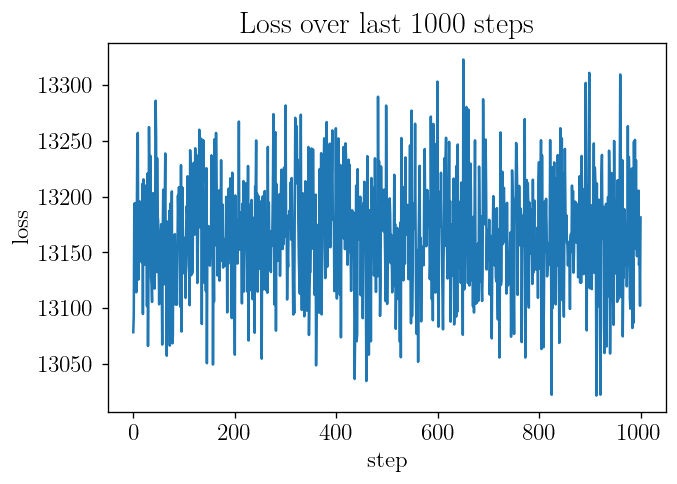

In [7]:
# check last 1000 steps of loss
plt.plot(svi_results.losses[-1000:])
plt.xlabel('step')
plt.ylabel('loss')  
plt.title('Loss over last 1000 steps')

In [8]:
# this cell is different from v0.3, we now specify the templates that we want to sample from a list of names
# instead of just getting all the samples. 

rng_key, key = jax.random.split(rng_key) 
ebinmodel.predictive(ebinmodel.guide, num_samples = 1, params = svi_results.params)
ie = ebinmodel.ebin

keys = list(ebinmodel.pred(key, ie).keys()) # get keys
keys.remove('_auto_latent') # remove _auto_latent
if is_gp: 
    keys.append('log_rate') 

samples_dict = ebinmodel.cget_all_samples_vec(keys, key, 10000, svi_results, custom_mask = None) #v4 (vectorized)
samples_dict['log_rate_nmask'] = ebinmodel.cget_samples_vec('log_rate', key, 10000, svi_results, custom_mask = ebinmodel.normalization_mask) # samples in normalization mask
samples_dict['S_gp'] = jnp.exp(samples_dict['log_rate_nmask']).mean(axis = -1) # S_gp using normalization mask

#  generate GP across entire inner ROI with no PS / Disk masks
mask = cm.make_mask_total(
        nside=128,
        mask_ring=True,
        outer = 20.,
        inner = 0.,
    )
samples_dict['log_rate_cmask'] = ebinmodel.cget_samples_vec('log_rate', key, 10000, svi_results, custom_mask = mask) # samples in custom mask

In [9]:
# augment samples_dict to include entire maps of samples
temp_sample_dict = ef.generate_temp_sample_maps(samples_dict, ebinmodel, gp_samples = samples_dict['log_rate'], custom_num = 1000) # templates over inner ROI
temp_sample_dict_cmask = ef.generate_temp_sample_maps(samples_dict, ebinmodel, gp_samples = samples_dict['log_rate_cmask'], custom_num = 1000, custom_mask = mask) # template over custom mask

names = list(temp_sample_dict.keys())
for name in names:
    samples_dict[name] = temp_sample_dict[name]
    samples_dict[name + '_cmask'] = temp_sample_dict_cmask[name]

iso
psc
bub
pib


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 465.91it/s]


ics


100%|██████████| 1000/1000 [00:01<00:00, 530.63it/s]


iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 503.77it/s]


ics


100%|██████████| 1000/1000 [00:01<00:00, 524.04it/s]


In [10]:
# save svi results and samples to file
file_name = ('ebin' + str_ebin + '_smp_svi_' + 
            str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

pickle.dump(
    (samples_dict, svi_results), 
    open(fit_dir + file_name, 'wb'))

In [11]:
# load true data if exits
if data_file != 'fermi_data_sum':
    temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()
else:
    pass

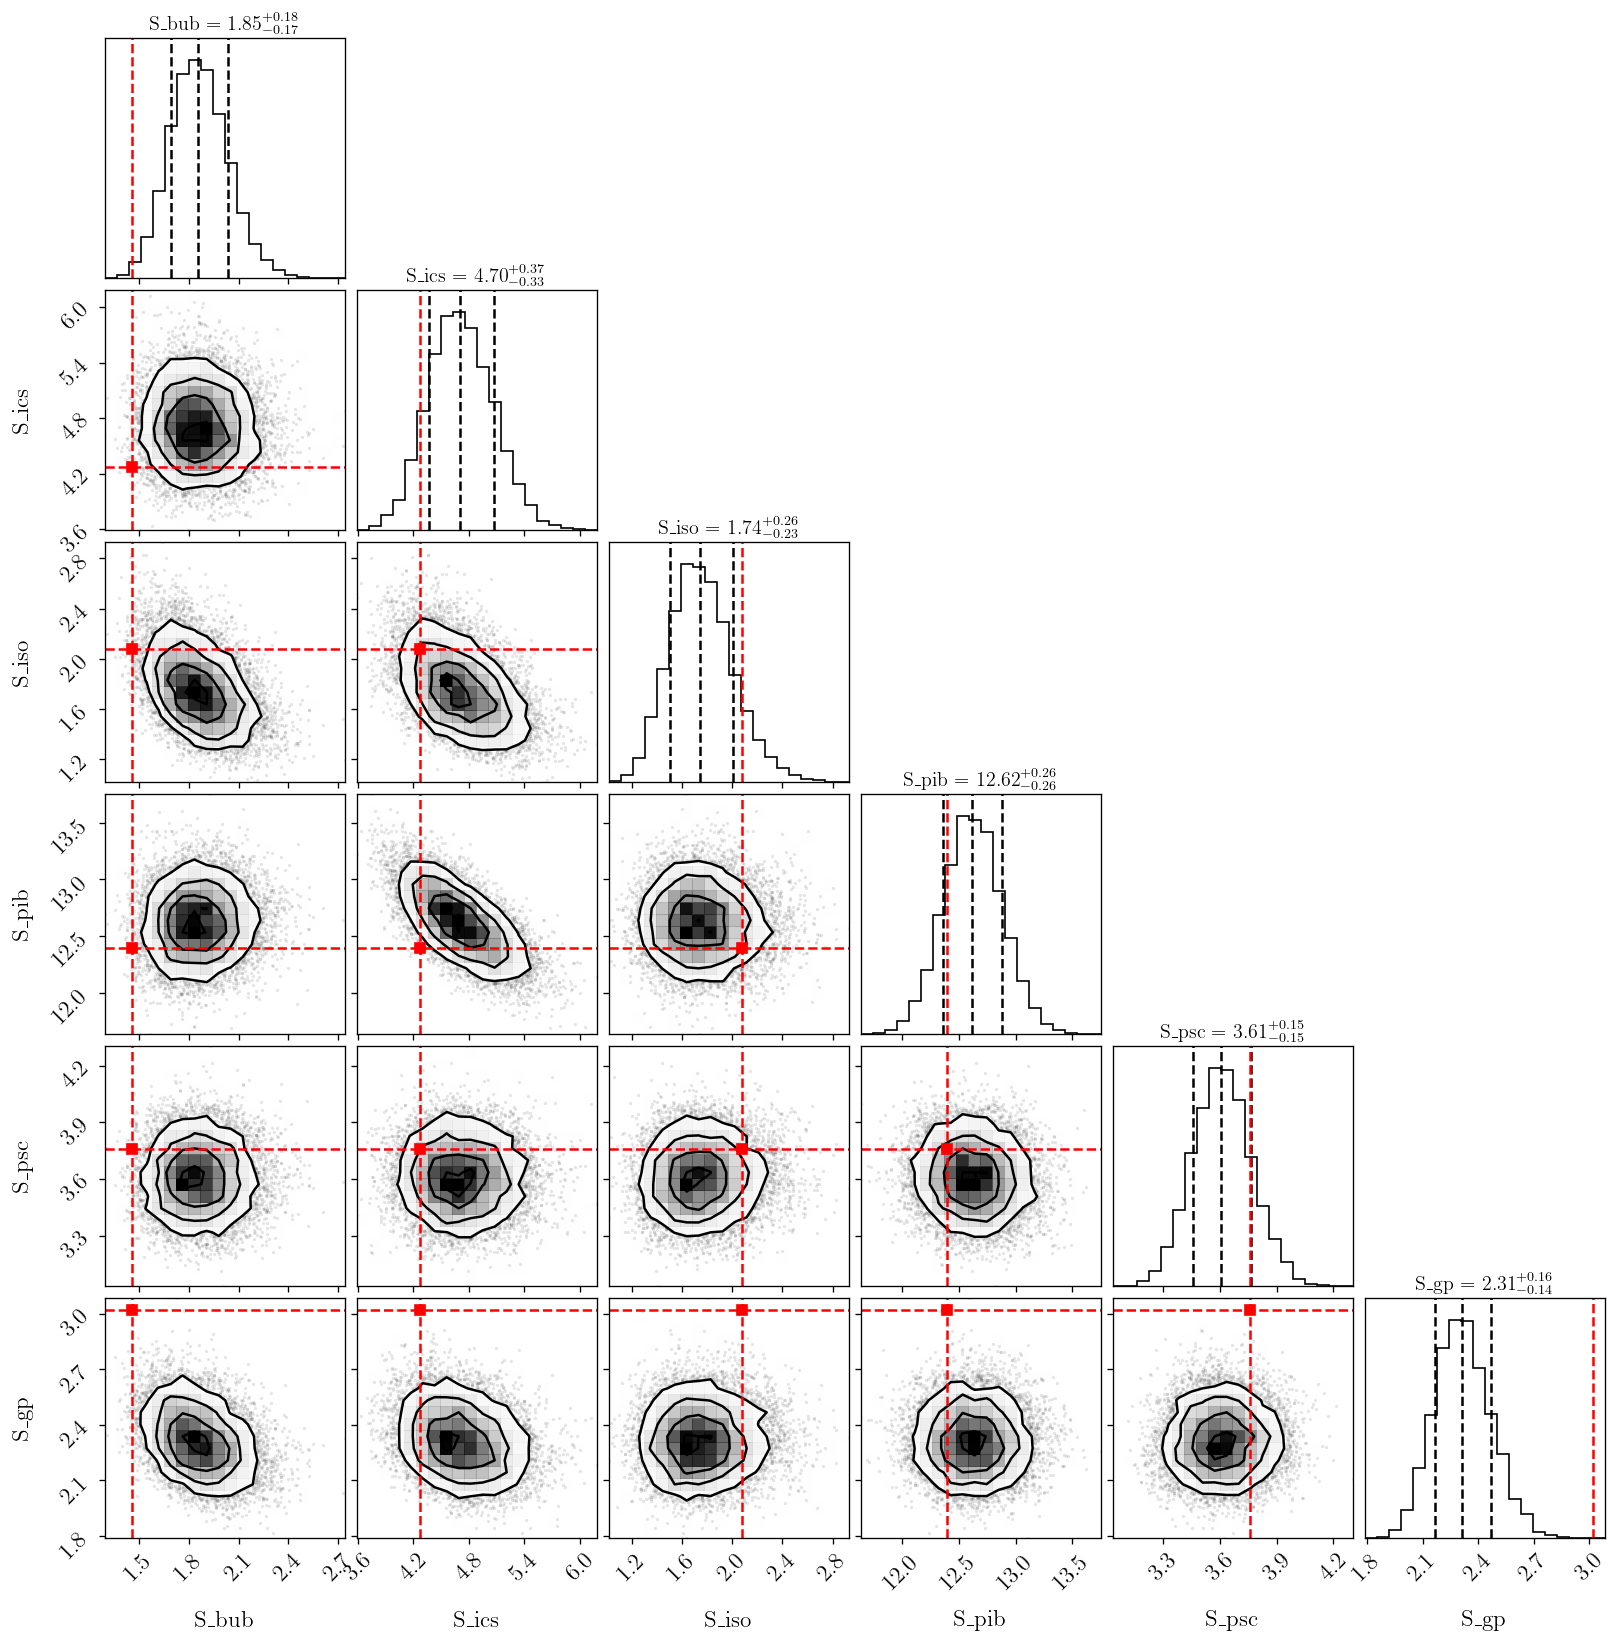

In [12]:
# generate corner plots
corner_keys = [k for k in list(samples_dict.keys()) if 'S_' in k]
corner_samples = {k : samples_dict[k] for k in corner_keys}

if data_file != 'fermi_data_sum':
    fig = ef.make_corner_plots(corner_samples, with_mean_vlines = False, sim_vlines = True, temp_dict = temp_dict)
else:
    fig = ef.make_corner_plots(corner_samples, with_mean_vlines = False, sim_vlines = False, temp_dict = None)

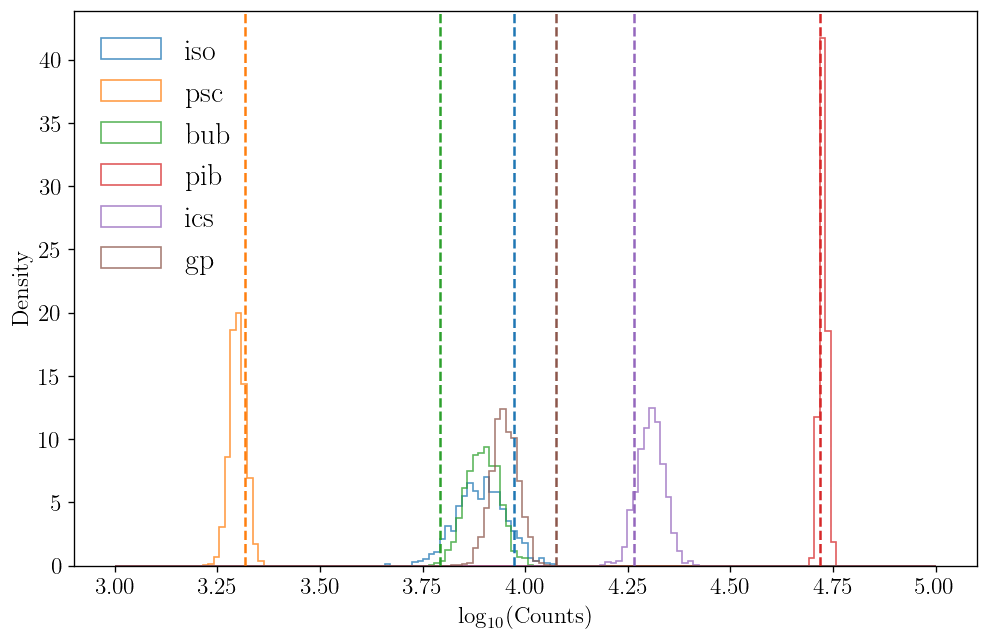

In [13]:
# generate samples and plot histograms of log counts
mask_p = ebinmodel.mask_roi_arr[ebin]
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
if data_file != 'fermi_data_sum':
    fig = ef.tot_log_counts_hist(temp_sample_dict, temp_dict, temp_names_sim, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False)
else:
    ef.tot_log_counts_hist(temp_sample_dict, None, None, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False)

/data/edr76/gce-gp/degeneracy_lr/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: FixedFormatter should only be used together w

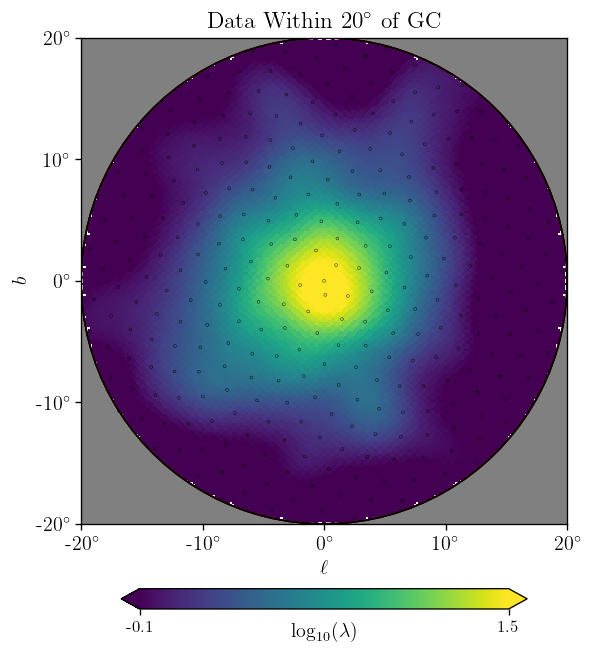

In [14]:
# Bottom: Data Processing 
fig, ax = plt.subplots(figsize=(6, 6), dpi= 120, nrows = 1, ncols = 1) # DEFINING AXES FROM HERE DOES NOT WORK SEE SUBPLOT ARGUMENT BELOW

q = np.percentile(temp_sample_dict_cmask['gp'], 50, axis = 0)
m = ef.convert_masked_array_to_hp_array(q, mask, log_option = True, nside = 128)
plt.axes(ax)
eplt.inner_roi_map(m, title = 'Data Within 20$^{\circ}$ of GC', vmin = -0.1, vmax = 1.5, subplot = 111)

xu_f = ebinmodel.xu_f
xu_f_r = np.deg2rad(xu_f)
plt.scatter(xu_f_r[:,0], xu_f_r[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)

In [15]:
ebinmodel_1 = ebinmodel
svi_results_1 = svi_results
samples_dict_1 = samples_dict
temp_sample_dict_1 = temp_sample_dict
temp_sample_dict_cmask_1 = temp_sample_dict_cmask
corner_samples_1 = corner_samples

In [16]:
# INPUT CELL

summary = 'Fit simulated dataset with standard GP model. Need to perform 100 fits and all appendix-related analysis with these settings.'
gpu_id = '0'

mod_id = 11 # following notebooks_canon format
svi_id = 672
sim_seed = 1000 ; str_sim_seed = str(sim_seed)

# Important Fit Settings 
rig_temp_list = ['iso', 'psc', 'bub'] # 'iso', 'psc', 'bub'
hyb_temp_list = ['pib', 'ics'] # pib, ics, blg
var_temp_list = [] # nfw, dsk

is_gp = True
gp_deriv = False

blg_id = 1 # Coleman2019 bulge
data_file = 'canon_g1p2_ola_v2'
rig_temp_sim = ['iso', 'psc', 'bub']
hyb_temp_sim = ['pib', 'ics', 'blg']
var_temp_sim = ['nfw']
is_custom_blg = False
custom_blg_id = 0

Nu = 300
u_option = 'fixed' # 'float' or 'fixed'
u_grid_type = 'sunflower'
u_weights = 'data'

Np = 50
p_option = 'match_u' # 'float' or 'fixed'
Nsub = 500

# Rest of parameters set to default values
ebin = 10
is_float64 = False
debug_nans = False
no_ps_mask = False
p_grid_type = 'healpix_bins'
p_weights = None
gp_kernel = 'Matern32'
gp_params = ['float', 'float']
gp_scale_option = 'Linear' # 'Linear' or 'Cholesky'
monotonicity_hyperparameter = 0.01
nfw_gamma = 'vary'
blg_names = ef.gen_blg_name_(blg_id) # needed only for saving in this case
dif_names = ['gceNNo']

# fit specs, strings loaded for file saving

ebin = 10
str_ebin = str(ebin)

guide = 'mvn'
str_guide = guide

n_steps = 100000
str_n_steps = str(n_steps)

lr = 0.0001
str_lr = str(lr)   # BE SURE TO CHANGE THIS

num_particles = 8
str_num_particles = str(num_particles)

svi_seed = 0
str_svi_seed = str(svi_seed)

In [17]:
# # load GPU
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
# os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

# directory where the data stored
data_dir = ef.load_data_dir(data_file)

# directory where fits stored
fit_filename, module_name = ef.generate_fit_filename(rig_temp_list, hyb_temp_list, var_temp_list, rig_temp_sim, hyb_temp_sim, var_temp_sim, is_gp, gp_deriv, is_custom_blg, custom_blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
os.system("mkdir -p "+fit_dir)

# command that converts numbers/strings to text strings
txt = lambda x: ('\'' + str(x) + '\'')

# save settings to module

with open(fit_dir + '__init__' +  '.py', 'w') as i:
    i.write('')

with open(fit_dir + module_name + '.py', 'w') as f:
    f.write('# Important Model Settings\n')
    f.write('rig_temp_list = ' + str(rig_temp_list) + '\n')
    f.write('hyb_temp_list = ' + str(hyb_temp_list) + '\n')
    f.write('var_temp_list = ' + str(var_temp_list) + '\n')
    f.write('is_gp = ' + str(is_gp) + '\n')
    f.write('gp_deriv = ' + str(gp_deriv) + '\n')
    f.write('data_file = ' + txt(data_file) + '\n')
    f.write('dif_names = ' + str(dif_names) + '\n')
    f.write('rig_temp_sim = ' + str(rig_temp_sim) + '\n')
    f.write('hyb_temp_sim = ' + str(hyb_temp_sim) + '\n')
    f.write('var_temp_sim = ' + str(var_temp_sim) + '\n')
    f.write('is_custom_blg = ' + str(is_custom_blg) + '\n')
    f.write('custom_blg_id = ' + str(custom_blg_id) + '\n')
    f.write('sim_seed = ' + str(sim_seed) + '; str_sim_seed = ' + txt(sim_seed) + '\n')
    f.write('Nu = ' + str(Nu) + '\n')
    f.write('u_option = ' + txt(u_option) + '\n')
    f.write('u_grid_type = ' + txt(u_grid_type) + '\n')
    f.write('u_weights = ' + txt(u_weights) + '\n')
    f.write('Np = ' + str(Np) + '\n')
    f.write('p_option = ' + txt(p_option) + '\n')
    f.write('Nsub = ' + str(Nsub) + '\n')
    f.write('\n')
    f.write('# Rest of model parameters set to default values\n')
    f.write('ebin = ' + str(ebin) + '\n')
    f.write('is_float64 = ' + str(is_float64) + '\n')
    f.write('debug_nans = ' + str(debug_nans) + '\n')
    f.write('no_ps_mask = ' + str(no_ps_mask) + '\n')
    f.write('p_grid_type = ' + txt(p_grid_type) + '\n')
    f.write('p_weights = ' + str(p_weights) + '\n')
    f.write('gp_kernel = ' + txt(gp_kernel) + '\n')
    f.write('gp_params = ' + str(gp_params) + '\n')
    f.write('gp_scale_option = ' + txt(gp_scale_option) + '\n')
    f.write('monotonicity_hyperparameter = ' + str(monotonicity_hyperparameter) + '\n')
    if nfw_gamma == 'vary':
        f.write('nfw_gamma = ' + txt(nfw_gamma) + '\n')
    else:
        f.write('nfw_gamma = ' + str(nfw_gamma) + '\n')
    f.write('blg_names = ' + str(blg_names) + '\n\n')

# add these additional parameters and the str_ versions to text file
with open(fit_dir + module_name + '.py', 'a') as f:
    f.write('\n')
    f.write('# SVI Parameters \n')
    f.write('ebin = ' + str(ebin) + '\n')
    f.write('str_ebin = str(ebin)' + '\n')
    f.write('guide = ' + txt(guide) + '\n')
    f.write('str_guide = guide' + '\n')
    f.write('n_steps = ' + str(n_steps) + '\n')
    f.write('str_n_steps = str(n_steps)' + '\n')
    f.write('lr = ' + str(lr) + '\n')
    f.write('str_lr = ' + txt(lr) + '\n')
    f.write('num_particles = ' + str(num_particles) + '\n')
    f.write('str_num_particles = str(num_particles)' + '\n')
    f.write('svi_seed = ' + str_svi_seed + '\n')
    f.write('str_svi_seed = ' + txt(str_svi_seed))

# add summary to its own text file
with open(fit_dir + 'summary' + '.txt', 'w') as f:
    f.write(summary)

In [18]:
from models.poissonian_gp_no_outer import EbinPoissonModel

ebinmodel = EbinPoissonModel(
        # important parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg = is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,

        # default parameters
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma = nfw_gamma,
        blg_names = blg_names,
        dif_names = dif_names,
        )

In [19]:
# define custom optimizer (can be None if want to use default)
optimizer = None

In [20]:
# configure model, run SVI, and generate samp 
rng_key = jax.random.PRNGKey(sim_seed) #new
rng_key, key = jax.random.split(rng_key)
ebinmodel.config_model(ebin=ebin)
svi_results = ebinmodel.cfit_SVI(
    rng_key=key,
    guide=guide, 
    n_steps=n_steps, 
    lr=lr, 
    num_particles=num_particles,
    ebin=ebin, optimizer = optimizer,
    record_states = True, record_min = False, progress_bar = True,
    init_loc_fn = init_to_sample #new
)

100%|██████████| 100000/100000 [15:50<00:00, 105.20it/s, init loss: 580331.0625, min loss inf, avg loss [99501-100000]: 13206.9902]


Text(0.5, 1.0, 'Loss over last 1000 steps')

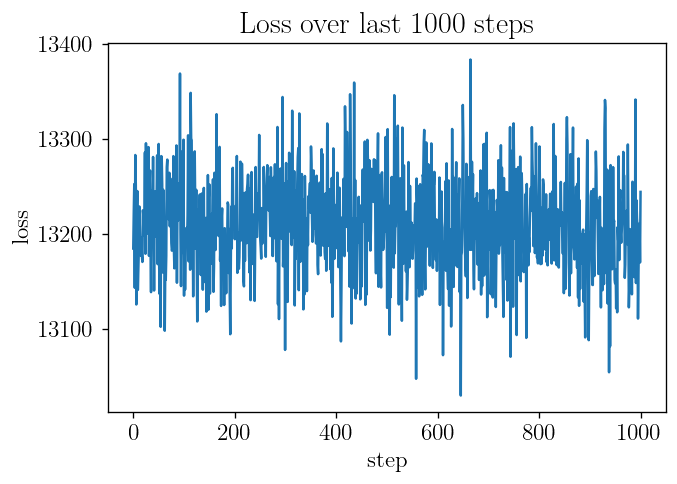

In [21]:
# check last 1000 steps of loss
plt.plot(svi_results.losses[-1000:])
plt.xlabel('step')
plt.ylabel('loss')  
plt.title('Loss over last 1000 steps')

In [22]:
# this cell is different from v0.3, we now specify the templates that we want to sample from a list of names
# instead of just getting all the samples. 

rng_key, key = jax.random.split(rng_key) 
ebinmodel.predictive(ebinmodel.guide, num_samples = 1, params = svi_results.params)
ie = ebinmodel.ebin

keys = list(ebinmodel.pred(key, ie).keys()) # get keys
keys.remove('_auto_latent') # remove _auto_latent
if is_gp: 
    keys.append('log_rate') 

samples_dict = ebinmodel.cget_all_samples_vec(keys, key, 10000, svi_results, custom_mask = None) #v4 (vectorized)
samples_dict['log_rate_nmask'] = ebinmodel.cget_samples_vec('log_rate', key, 10000, svi_results, custom_mask = ebinmodel.normalization_mask) # samples in normalization mask
samples_dict['S_gp'] = jnp.exp(samples_dict['log_rate_nmask']).mean(axis = -1) # S_gp using normalization mask

#  generate GP across entire inner ROI with no PS / Disk masks
mask = cm.make_mask_total(
        nside=128,
        mask_ring=True,
        outer = 20.,
        inner = 0.,
    )
samples_dict['log_rate_cmask'] = ebinmodel.cget_samples_vec('log_rate', key, 10000, svi_results, custom_mask = mask) # samples in custom mask

In [23]:
# augment samples_dict to include entire maps of samples
temp_sample_dict = ef.generate_temp_sample_maps(samples_dict, ebinmodel, gp_samples = samples_dict['log_rate'], custom_num = 1000) # templates over inner ROI
temp_sample_dict_cmask = ef.generate_temp_sample_maps(samples_dict, ebinmodel, gp_samples = samples_dict['log_rate_cmask'], custom_num = 1000, custom_mask = mask) # template over custom mask

names = list(temp_sample_dict.keys())
for name in names:
    samples_dict[name] = temp_sample_dict[name]
    samples_dict[name + '_cmask'] = temp_sample_dict_cmask[name]

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 542.58it/s]


ics


100%|██████████| 1000/1000 [00:01<00:00, 520.64it/s]


iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 539.90it/s]


ics


100%|██████████| 1000/1000 [00:01<00:00, 540.87it/s]


In [24]:
# save svi results and samples to file
file_name = ('ebin' + str_ebin + '_smp_svi_' + 
            str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

pickle.dump(
    (samples_dict, svi_results), 
    open(fit_dir + file_name, 'wb'))

In [25]:
# load true data if exits
if data_file != 'fermi_data_sum':
    temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()
else:
    pass

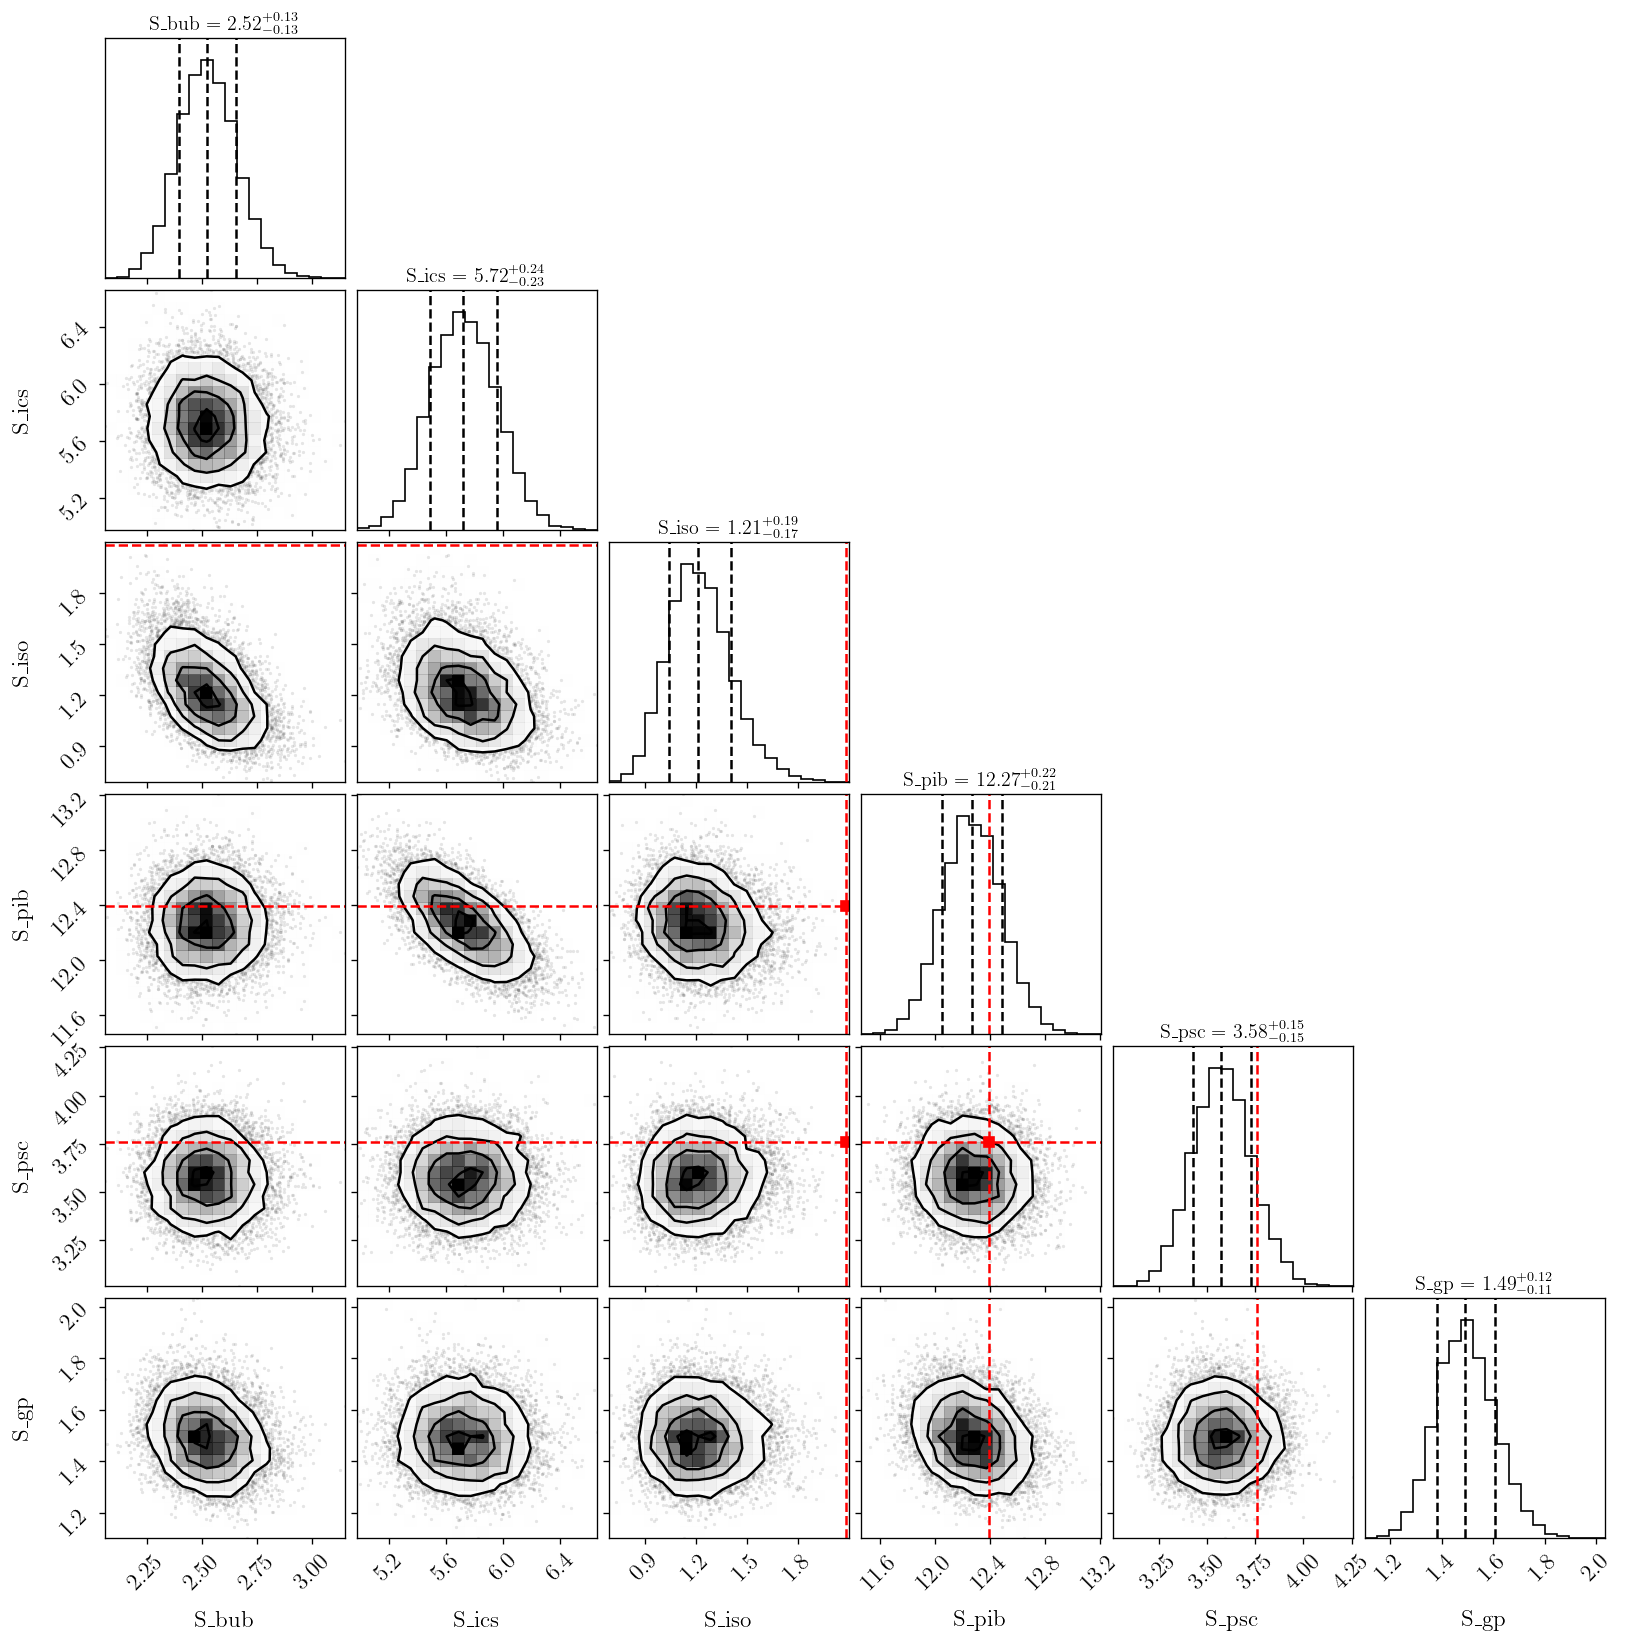

In [26]:
# generate corner plots
corner_keys = [k for k in list(samples_dict.keys()) if 'S_' in k]
corner_samples = {k : samples_dict[k] for k in corner_keys}

if data_file != 'fermi_data_sum':
    fig = ef.make_corner_plots(corner_samples, with_mean_vlines = False, sim_vlines = True, temp_dict = temp_dict)
else:
    fig = ef.make_corner_plots(corner_samples, with_mean_vlines = False, sim_vlines = False, temp_dict = None)

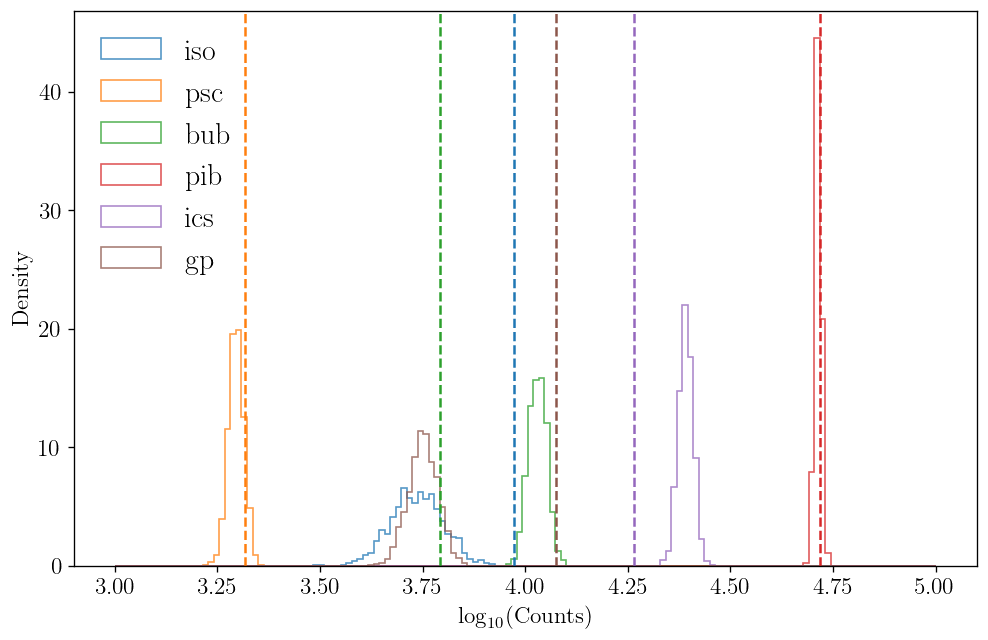

In [27]:
# generate samples and plot histograms of log counts
mask_p = ebinmodel.mask_roi_arr[ebin]
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
if data_file != 'fermi_data_sum':
    fig = ef.tot_log_counts_hist(temp_sample_dict, temp_dict, temp_names_sim, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False)
else:
    ef.tot_log_counts_hist(temp_sample_dict, None, None, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False)

/data/edr76/gce-gp/degeneracy_lr/../utils/ed_fcts_amarel.py:665: RuntimeWarning: divide by zero encountered in log10
  hp_map = hp.ma(np.log10(full_array))
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.1, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")
/home/edr76/.conda/envs/jax/lib/python3.11/site-packages/healpy/newvisufunc.py:621: UserWarning: FixedFormatter should only be used together w

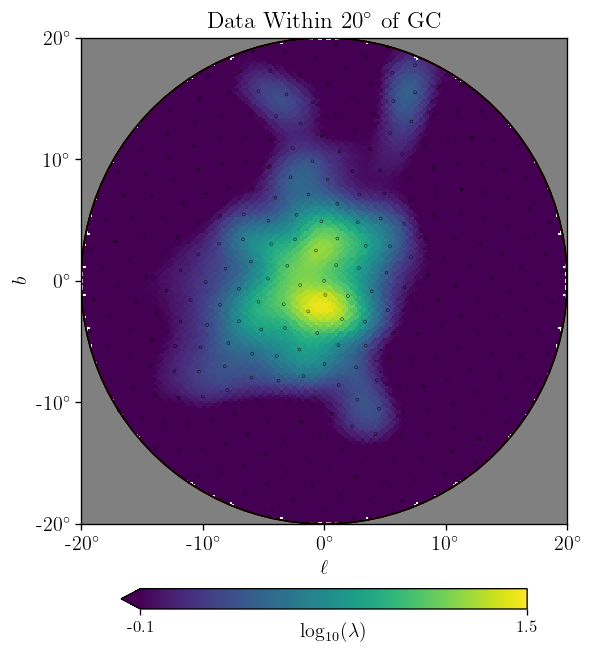

In [28]:
# Bottom: Data Processing 
fig, ax = plt.subplots(figsize=(6, 6), dpi= 120, nrows = 1, ncols = 1) # DEFINING AXES FROM HERE DOES NOT WORK SEE SUBPLOT ARGUMENT BELOW

q = np.percentile(temp_sample_dict_cmask['gp'], 50, axis = 0)
m = ef.convert_masked_array_to_hp_array(q, mask, log_option = True, nside = 128)
plt.axes(ax)
eplt.inner_roi_map(m, title = 'Data Within 20$^{\circ}$ of GC', vmin = -0.1, vmax = 1.5, subplot = 111)

xu_f = ebinmodel.xu_f
xu_f_r = np.deg2rad(xu_f)
plt.scatter(xu_f_r[:,0], xu_f_r[:,1], facecolors = 'none', edgecolors = 'k', s = 3, lw = 0.25)

In [29]:
ebinmodel_2 = ebinmodel
svi_results_2 = svi_results
samples_dict_2 = samples_dict
temp_sample_dict_2 = temp_sample_dict
temp_sample_dict_cmask_2 = temp_sample_dict_cmask
corner_samples_2 = corner_samples

In [30]:
# compare loss and NLL evolution
ll_list_1 = ebinmodel_1.recorded_log_likelihoods_1(num_samples = 16)
ll_list_2 = ebinmodel_2.recorded_log_likelihoods_1(num_samples = 16)

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:14<00:00, 28.34it/s]


Text(0.5, 0, 'normalized step')

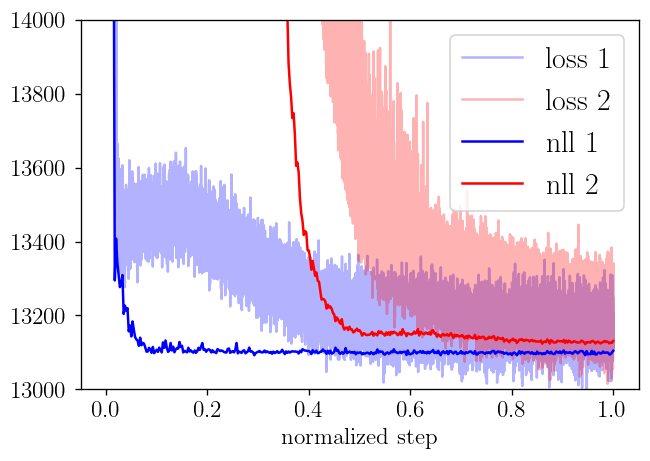

In [31]:
# note requires predictive distribution, which was loaded two cells up
ll_list_1 = jnp.array(ll_list_1)
losses_1 = jnp.array(svi_results_1.losses)
Nstep1 = len(svi_results_1.losses)
ll_list_2 = jnp.array(ll_list_2)
losses_2 = jnp.array(svi_results_2.losses)
Nstep2 = len(svi_results_2.losses)

x1 = np.arange(1, Nstep1 + 1) / Nstep1
x2 = np.arange(1, Nstep2 + 1) / Nstep2
rx1 = ( np.array(svi_results_1.recorded_steps)  ) / Nstep1
rx2 = ( np.array(svi_results_2.recorded_steps) ) / Nstep2

plt.plot(x1, losses_1, label = 'loss 1', c = 'b', alpha = 0.3)
plt.plot(x2, losses_2, label = 'loss 2', c = 'r', alpha = 0.3)
plt.plot(rx1 , -ll_list_1, label = 'nll 1', c = 'b')  
plt.plot(rx2, -ll_list_2, label = 'nll 2', c = 'r')
plt.ylim(13000,14000)
plt.legend()
plt.xlabel('normalized step')

In [32]:
floss_1 = np.log10(svi_results_1.losses[-1])
floss_2 = np.log10(svi_results_2.losses[-1])
print(floss_1 - floss_2)

-0.0020747185


In [33]:
floss_1 = svi_results_1.losses[-1]
floss_2 = svi_results_2.losses[-1]
print((floss_1 - floss_2) / floss_1)

-0.004788683


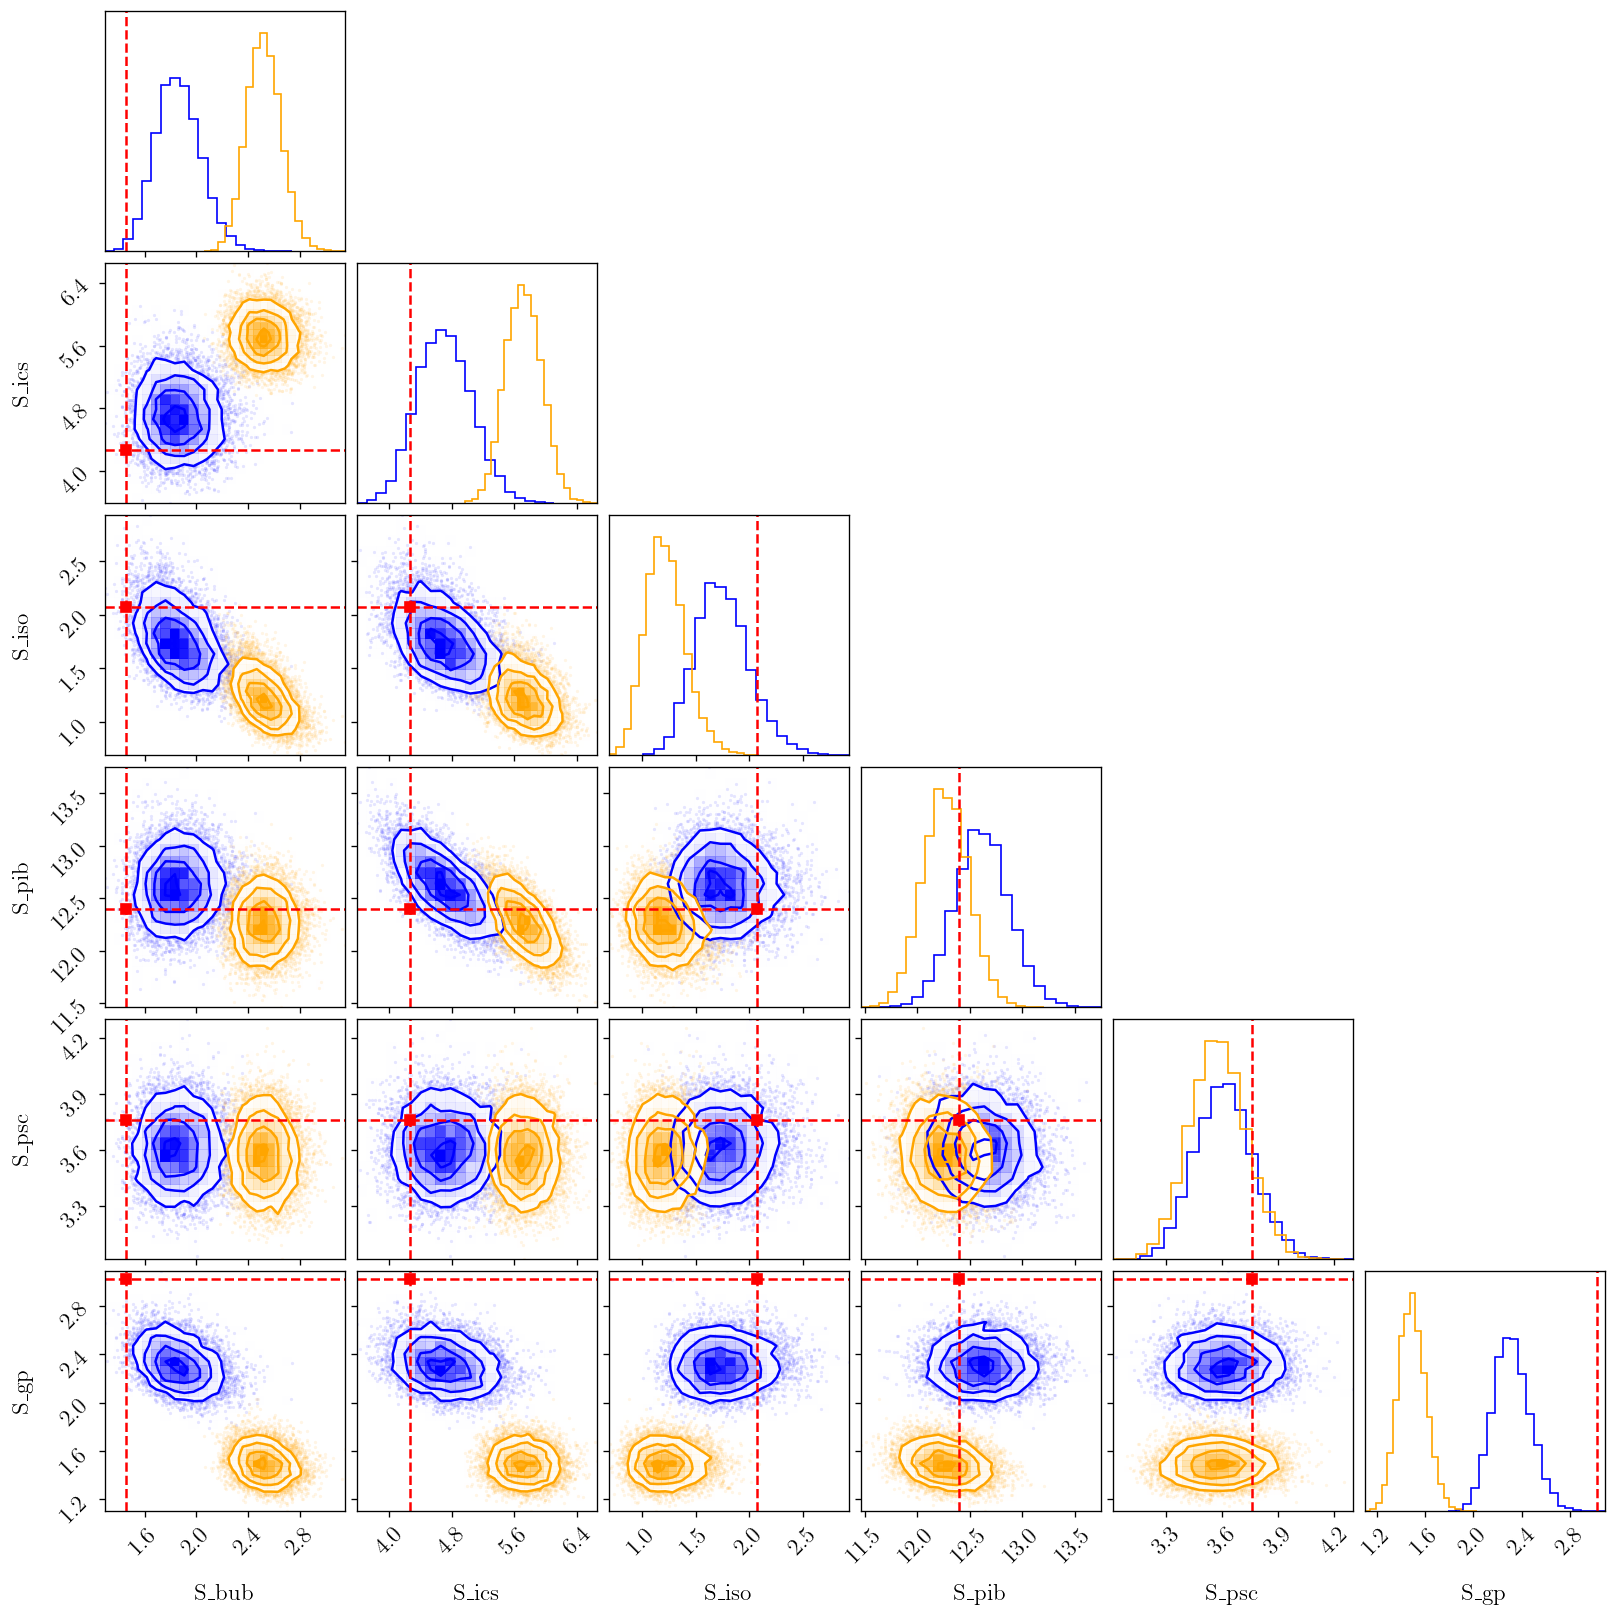

In [34]:
names = list(corner_keys)

template_sample_array_1 = np.zeros((len(names), 8000))
for i in range(len(names)):
    name = names[i]
    template_sample_array_1[i] = corner_samples_1[name][:8000]

template_sample_array_2 = np.zeros((len(names), len(corner_samples_2[names[0]])))
for i in range(len(names)):
    name = names[i]
    template_sample_array_2[i] = corner_samples_2[name]

fig = corner.corner(template_sample_array_1.T, labels=names, show_titles=False, density = True, 
                    color = 'blue')
corner.corner(template_sample_array_2.T, labels=names, show_titles=False, fig=fig, density = True, 
              color = 'orange')

N_var = len(names)
axes = np.array(fig.axes).reshape((N_var, N_var))

for i in range(len(names)):
    name = names[i]
    ax = axes[i,i]
    if name == 'S_gp':
        ax.axvline(temp_dict['S_nfw'] + temp_dict['S_blg'], color='red', linestyle='--')
    if name not in list(temp_dict.keys()):
        continue
    else:
        ax.axvline(temp_dict[name], color='red', linestyle='--')

for yi in range(len(names)):
    for xi in range(yi):
        ax = axes[yi,xi]
        name_x = names[xi]
        name_y = names[yi]
        if (name_x == 'S_gp') & (name_y != 'S_gp'):
            value_x = temp_dict['S_nfw'] + temp_dict['S_blg']
            value_y = temp_dict[name_y]
        elif (name_x != 'S_gp') & (name_y == 'S_gp'):
            value_x = temp_dict[name_x]
            value_y = temp_dict['S_nfw'] + temp_dict['S_blg']
        elif name_x not in list(temp_dict.keys()):
            continue
        elif name_y not in list(temp_dict.keys()):
            continue
        else:
            value_x = temp_dict[name_x]
            value_y = temp_dict[name_y]

        ax.axvline(value_x, color='red', linestyle='--')
        ax.axhline(value_y, color='red', linestyle='--')
        ax.plot(value_x, value_y, "sr")

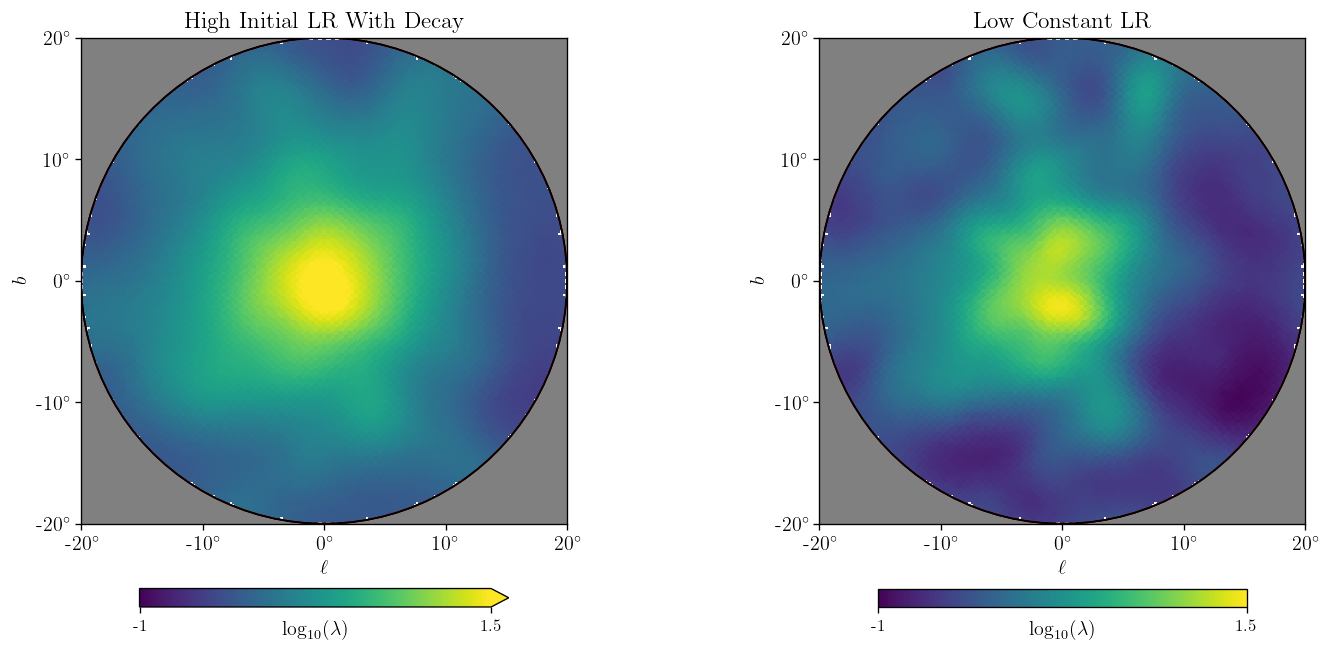

In [35]:
# Bottom: Data Processing 
fig, ax = plt.subplots(figsize=(12, 6), dpi= 120, nrows = 1, ncols = 2) # DEFINING AXES FROM HERE DOES NOT WORK SEE SUBPLOT ARGUMENT BELOW

q = np.percentile(temp_sample_dict_cmask_1['gp'], 50, axis = 0)
m = ef.convert_masked_array_to_hp_array(q, mask, log_option = True, nside = 128)
plt.axes(ax[0])
eplt.inner_roi_map(m, title = 'High Initial LR With Decay', vmin = -1, vmax = 1.5, subplot = 121)

q = np.percentile(temp_sample_dict_cmask_2['gp'], 50, axis = 0)
m = ef.convert_masked_array_to_hp_array(q, mask, log_option = True, nside = 128)
plt.axes(ax[1])
eplt.inner_roi_map(m, title = 'Low Constant LR', vmin = -1, vmax = 1.5, subplot = 122)

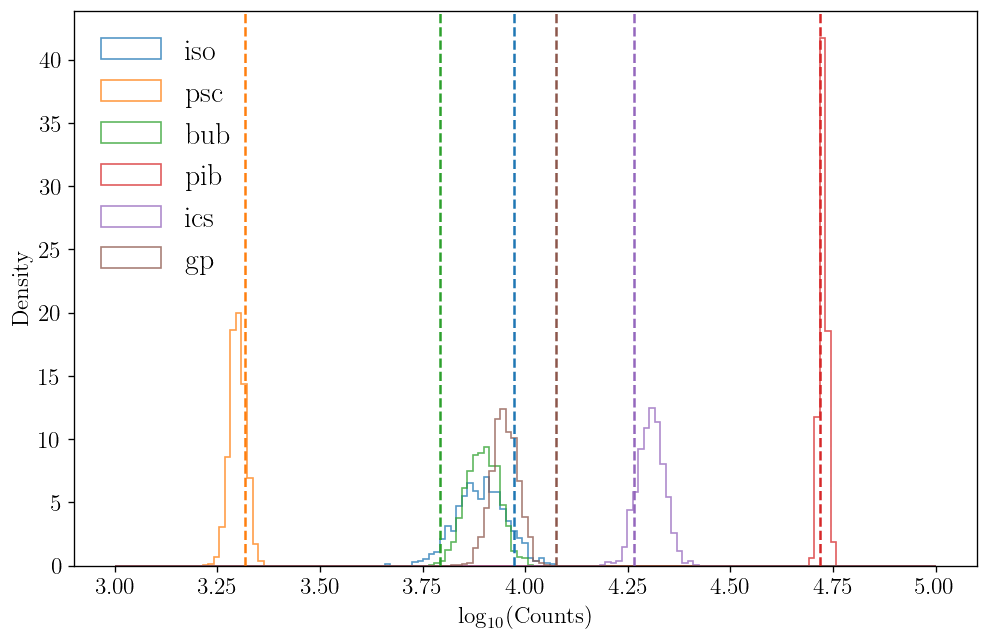

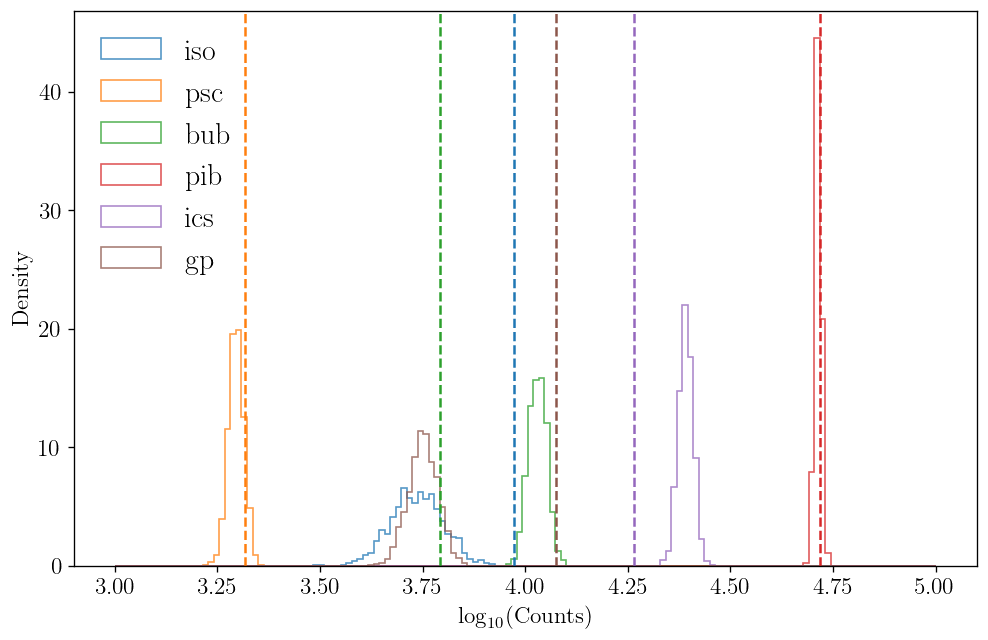

In [36]:
# generate samples and plot histograms of log counts
mask_p = ebinmodel.mask_roi_arr[ebin]
temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
ef.tot_log_counts_hist(temp_sample_dict_1, temp_dict, temp_names_sim, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False)
ef.tot_log_counts_hist(temp_sample_dict_2, temp_dict, temp_names_sim, mask = mask_p, bins = np.linspace(3.,5.,150), gp_model_nfw=True, gp_model_iso = False)



In [37]:
# save loss data
file_name = ('ebin' + str_ebin + '_loss_data_' + 
            str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

pickle.dump(
    (losses_1, ll_list_1, losses_2, ll_list_2), 
    open(fit_dir + file_name, 'wb'))

In [38]:
# last plot to show might be comparing the total rate on 1D slices like shown in report 23 slide 14

: 